In [1]:
### This is a script to select athletes from the Golden Cheetah OpenData for local storage and then access the individual activities containing power data for the year specified in a key. 

The first part of the script uses the MMP data to creat a key that meets the following critera:
1. Athlete has at least 100 power files for the year.
2. The MMP for the year is at least 7200 seconds in duration.
3. The MMP does not have obvious outlier data based on known virtual power issues and CP model parameters

The first section below is adapted from <a href="https://twitter.com/liversedge?ref_src=twsrc%5Egoogle%7Ctwcamp%5Eserp%7Ctwgr%5Eauthor">Mark's</a> 
<a href="http://markliversedge.blogspot.com/2018/11/getting-started-with-goldencheetah.html">BasicOpenDataNotebook</a>.

In [2]:
##get some some libraries
import pandas 
import numpy 
import math
import random
import datetime
import requests
import io
import zipfile
import statistics
from dateutil.parser import parse
from scipy.interpolate import splrep, splev
from scipy.stats import zscore
from scipy.stats import norm
from scipy.stats import linregress
from scipy.stats import gamma
from scipy.stats import geom
import statsmodels.formula.api as smf
from lmfit import minimize, Parameters
# plotting with matplot
import matplotlib
import matplotlib.pyplot as plt
%matplotlib notebook




Before running the next line it is a good idea to think about where you want the OpenData stored. See the README <a href="https://github.com/GoldenCheetah/OpenData/blob/master/opendata-python/README.md">OpenData</a> and thank <a href="https://twitter.com/aartgoossens?lang=en">Aart</a> for his work on the library.

In [3]:
from opendata import OpenData
od = OpenData()

Local storage directory (C:\Users\mpuchowi\opendatastorage) created


In [4]:
## Read the remote zip file and the csv file zipped into it into a pandas dataframe
response = requests.get('https://s3.amazonaws.com/goldencheetah-opendata/datasets/activities_mmp.csv.zip')
zf = zipfile.ZipFile(io.BytesIO(response.content))
mmps = pandas.read_csv(zf.open('activities_mmp.csv'))

In [5]:
plt.rcParams['figure.figsize'] = [12, 9]

In [6]:
#mmps.head()

In [7]:
# remove known problems .. these two indicate virtual power algorithms
mmps =mmps.drop(mmps[mmps['1']==2000].index)
mmps =mmps.drop(mmps[mmps['1']==1000].index)

# remove values outside the 99% percentile
mmps =mmps.drop(mmps[mmps['1']>2452].index)
mmps =mmps.drop(mmps[mmps['180']>516].index)
mmps =mmps.drop(mmps[mmps['420']>453].index)
mmps =mmps.drop(mmps[mmps['720']>438].index)
mmps =mmps.drop(mmps[mmps['1200']>414].index)

# remove spikey data
mmps =mmps.drop(mmps[mmps['1']>(mmps['5']*1.3)].index)
mmps =mmps.drop(mmps[mmps['1']>(mmps['2']*1.2)].index)
mmps =mmps.drop(mmps[mmps['1']==mmps['2']].index)

# no weight available
mmps =mmps.drop(mmps[mmps['weight']<=0].index)
len(mmps)

353663

In [8]:
# add month and year column
def year(df):
    return parse(df['date']).year
def month(df):
    return parse(df['date']).month

mmps['month'] = mmps.apply(lambda row: month(row), axis=1)
mmps['year'] = mmps.apply(lambda row: year(row), axis=1)

In [9]:
# aggregate year and monthly bests - will take a while ! activate athlete_months if desired
athlete_years = mmps.groupby(['id','year'], as_index=False).max()
athlete_years_count = mmps.groupby(['id','year'], as_index=False).count()
athlete_years['count'] = athlete_years_count['1']
#athlete_months = mmps.groupby(['id','year', 'month'], as_index=False).max()

In [10]:
athlete_years_sum = mmps.groupby(['id','year'], as_index=False).sum()
athlete_years['distance'] = athlete_years_sum['distance']
athlete_years['duration'] = athlete_years_sum['duration']

In [11]:
#athlete_years.head()

In [12]:
## get years with decent enough data >100 workouts
full_athlete_years = athlete_years.drop(athlete_years[athlete_years['count']<100].index)

In [13]:
## get years with decent enough duration > 7200
full_athlete_years = full_athlete_years.drop(full_athlete_years[full_athlete_years['duration']<7200].index)

In [14]:
len(full_athlete_years)

1375

In [15]:
## use 3 parameter CP model to filter 

## use 3,7,12 to estimate CP and W'
def cp3res(params, x, data):
    cp = params['cp']
    w = params['w']
    k = params['k']
    model = cp + (w/(x+k))
    return (data-model)

def cp3(df):
    params = Parameters()
    params.add('cp', value=250)
    params.add('w', value=18000)
    params.add('k', value=32)

    # x and y
    x = [15,20,60,180,420,720]
    y = [df['15'],df['20'],df['60'],df['180'],df['420'],df['720']] 
    if (math.isfinite(y[0]) and math.isfinite(y[1]) and math.isfinite(y[2]) and math.isfinite(y[3]) and math.isfinite(y[4]) and math.isfinite(y[5])):
        out = minimize(cp3res, params, args=(x, y))
        return out.params['cp'].value, out.params['w'].value, out.params['cp'].value+(out.params['w'].value/(1+out.params['k'].value))
    return 0,0,0

In [16]:
# get estimates in a tuple
full_athlete_years['est']=full_athlete_years.apply(lambda row: cp3(row), axis=1)

In [17]:
full_athlete_years[['cp','w','pmax']] =full_athlete_years['est'].apply(pandas.Series)

In [18]:
## clean up a bit
full_athlete_years =full_athlete_years.drop(['est'], axis=1)

In [19]:
#clean out dodgy w' cp and pmax values
# remove dodgy W' values
full_athlete_years =full_athlete_years.drop(full_athlete_years[full_athlete_years['w']<1000].index)
full_athlete_years =full_athlete_years.drop(full_athlete_years[full_athlete_years['w']>50000].index)

# remove dodgy CP values
full_athlete_years =full_athlete_years.drop(full_athlete_years[full_athlete_years['cp']<100].index)
full_athlete_years =full_athlete_years.drop(full_athlete_years[full_athlete_years['cp']>500].index)

## get rid of dodgy pmax values
full_athlete_years =full_athlete_years.drop(full_athlete_years[full_athlete_years['pmax']>2500].index)
full_athlete_years =full_athlete_years.drop(full_athlete_years[full_athlete_years['pmax']<0].index)

# how many now?
len(full_athlete_years)

1265

In [20]:
## count how many unique athletes generated the MMPs
len(set(full_athlete_years['id']))

602

The 2 outputs are the total number of athlete-years meeting the criteria and the number of unique athletes respectively.

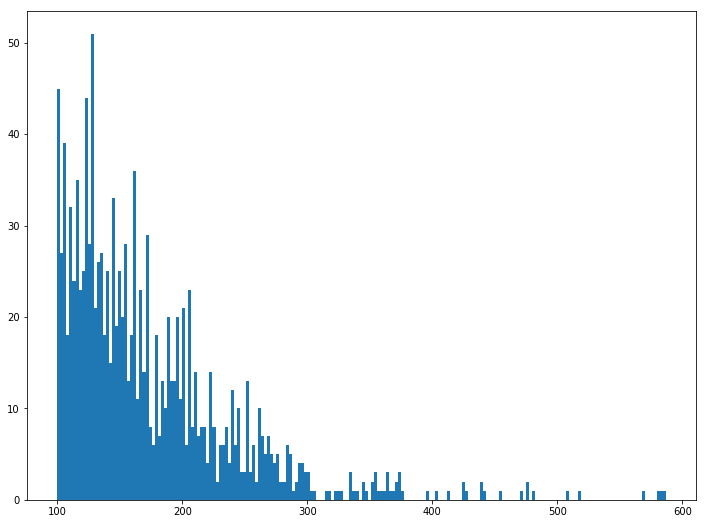

In [21]:
plot = plt.subplot()
z=plot.hist(full_athlete_years['count'], 200)

The plot above shows the distribution of the number of power files for the full year.

364


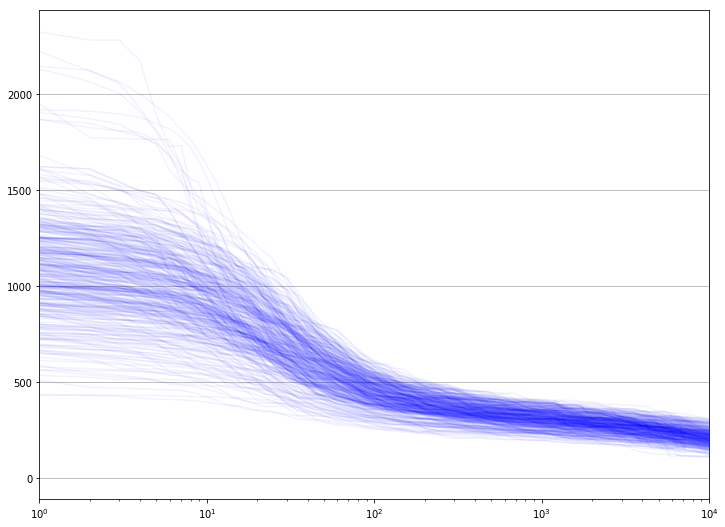

In [22]:
## lets look at all the curves

minr=0 # was interesting to filter based up 20:60 min power, this does all.

## overlay all the athlete seasons.
plot = plt.subplot()
plot.set_xscale('log') ## comment out if you don't want log-x scale
plot.grid(axis='y')
plt.xlim(1,10000) ## data beyond about 10000secs is not great

c=1
count=0
while (c < len(full_athlete_years)):

    ex=False
    ex=(c in full_athlete_years.index)
    

    if ex != False:
        x = []
        y = []
        for idx in range(7,len(mmps.columns)-3):
            xv=float(full_athlete_years.columns.values[idx])
            yv=float(full_athlete_years.loc[c][idx])
            if ((math.isfinite(xv)) & (math.isfinite(yv))):
                x.append(xv)
                y.append(yv)

        z=plot.plot(x, y, 'b-',alpha=0.05)
        count=count+1
        
    c=c+1



print(count)

Visualizing the MMPs

In [23]:
##make a key to subset the activities
key = pandas.DataFrame(full_athlete_years.loc[:,['id','year','duration']])

In [24]:
key = key.reset_index(drop=True)


In [25]:
##save the key to a csv
key.to_csv('GCOD_key.csv', sep=',')

In [26]:
#make a short key for testing stuff
shortkey = key[:4]

In [27]:
shortkey

,id,year,duration
0,000c6417-e1e4-497e-89e6-bb21e17ec355,2017,1304560.0
1,000c6417-e1e4-497e-89e6-bb21e17ec355,2018,2117532.0
2,0031326c-e796-4f35-8f25-d3937edca90f,2017,389755.0
3,025bad5c-1cfc-4c22-a2e3-2be1ccb70008,2014,795541.0


The object key stores the key for all the athlete-years meeting the criteria stated above. The shortkey object stores a few athlete-years for testing purposes.

The next step will actually go and get the models for each athlete year and store them localy. If you use the full 'key' it will take a while. Substitute the 'shortkey' to test things out.
At this point "data=False" so that the models are downloaded by not the full data yet. 


In [33]:
##get the selected athletes, note that if an athlete has more than one athlete-year then they are only saved once.

c = 0
while c < len(key):
    athlete = od.get_remote_athlete(key.id[c])
    athlete.store_locally(data=False)
    print(c)
    c = c + 1
    





0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [29]:
athletes = list(od.local_athletes())

In [32]:
len(athletes)


312

In [ ]:
def year(df):
    return parse(df['date']).year

##mmps['month'] = mmps.apply(lambda row: month(row), axis=1)
mmps['year'] = mmps.apply(lambda row: year(row), axis=1)

In [ ]:
#athletes


In [ ]:
len(shortkey)

In [ ]:
len(key)

Finally the loop below loops across the key to get each file with power data for the selected athlete-years.
Use 'shortkey' for testing and subsitute 'key' for the full list. Its probably a good idea to be very sure you want the data before downloading it as it will be over 100,000 .csv files ()

In [ ]:
##Loop to access each athlete and then each activity with power data for the year specified in shortkey 

##change to key if you want to run through the full local athlete list

for i in range(len(shortkey)):
    athlete = od.get_local_athlete(shortkey.id[i])
    activities = athlete.activities()
    print()
    print()
    print(shortkey.id[i])
    print()
    print()
        
    for activity in activities:
        if parse(activity.metadata['date']).year == key.year[i] and 'P' in activity.metadata['data'] :
            # add script to do some calculation on the data, get rid of the print to run faster
            print(parse(activity.metadata['date']).year)
            print(activity.metadata['data'])
        else:
            print('skip')
           
        

    

   

The plan next is to integrate interval discovery to reduce each ride file from a continuos vector of power data into a data frame of interval data. 